In [1]:
import QUANTAXIS as QA
from QAPUBSUB.consumer import subscriber  # 消费者
from QAPUBSUB.producer import publisher  # 生产者
import threading  # 在线程中运行消费者，防止线程阻塞
import json  # 消费者接收的数据是文本，转成json
import pandas as pd  # json转成DataFrame

jqdatasdk not installed
you are using non-interactive mdoel quantaxis


In [2]:
# 1. 账户准备
user = QA.QA_User(username='admin', password='admin')  # 账号密码跟81页面登录的账号密码一致
# portfolio_cookie就像是组合的id
port = user.new_portfolio(portfolio_cookie='x1')
# account_cookie就像是账户的id，init_cash是账户的初始资金，market_type为市场类型，QA中通过market_type预设了交易规则，例如期货允许t0等，与国内的交易规则一致。
acc = port.new_account(account_cookie='test_local_simpledeal', init_cash=100000, market_type=QA.MARKET_TYPE.FUTURE_CN)

 prortfolio with user_cookie  USER_1m5xbkUB  already exist!!


In [3]:
# 2. 发单操作方法
def sendorder(code, trade_price, trade_amount, trade_towards, trade_time):
	acc.receive_simpledeal(
		code=code,
		trade_price=trade_price,
		trade_amount=trade_amount,
		trade_towards=trade_towards,
		trade_time=trade_time)

In [4]:
# 3. 策略
market_data_list = []  # 存储历史数据
# 下面订阅数据时会指定on_data为回调函数，接到数据就会执行on_data
def on_data(a, b, c, data):
    # 数据准备
    bar = json.loads(data)
    market_data_list.append(bar)
    # 日线date格式是2019-01-01
    market_data_df = pd.DataFrame(market_data_list).set_index('date', drop=False)

    # 计算指标
    ind = QA.QA_indicator_MA(market_data_df, 2, 4)  # 计算MA2和MA4
    print(ind)
    
    # 策略逻辑
    MA2 = ind.iloc[-1]['MA2']  # 取最新的MA2
    MA4 = ind.iloc[-1]['MA4']  # 取最新的MA4
    code = bar['code']  # 合约代码
    trade_price = bar['close']  # 最新收盘价
    trade_amount = 1  # 1手
    trade_time = bar['date'] + ' 00:00:00'  # 由于日线date的格式是2019-01-01，所以要加后面的时间，否则无法计算指标，后面的问题章节有详细说明。
    code_hold_available = acc.hold_available.get(code, 0)  # 合约目前的持仓情况
    if MA2 > MA4:
        if code_hold_available == 0:
            print('买多')
            sendorder(code, trade_price, trade_amount, QA.ORDER_DIRECTION.BUY_OPEN, trade_time)
        elif code_hold_available > 0:
            print('持有')
        else:
            print('平空')
            sendorder(code, trade_price, trade_amount, QA.ORDER_DIRECTION.BUY_CLOSE, trade_time)
    elif MA4 > MA2:
        if code_hold_available == 0:
            print('卖空')
            sendorder(code, trade_price, trade_amount, QA.ORDER_DIRECTION.SELL_OPEN, trade_time)
        elif code_hold_available < 0:
            print('持有')
        else:
            print('平多')
            sendorder(code, trade_price, trade_amount, QA.ORDER_DIRECTION.SELL_CLOSE, trade_time)
    else:
        print('不操作')

In [5]:
# 4. 订阅数据
sub = subscriber(exchange='x1')  # Exchange名为x1，在15672页面能看到
sub.callback=on_data  # 指定回调函数
threading.Thread(target=sub.start).start()  # 开线程执行订阅，防止线程阻塞，后面的发布代码无法执行

In [6]:
# 5. 数据获取并推送数据
# 获取
df = QA.QA_fetch_get_future_day('tdx', 'RBL8', '2019-08-01', '2019-08-30')
# 推送
pub = publisher(exchange='x1')  # 跟订阅的Exchange一致
for idx, item in df.iterrows():
    pub.pub(item.to_json())  # 每行数据换成json，pub出去，上面的on_data就会收到，开始执行策略。

QUANTAXIS>> Selecting the Best Server IP of TDX


USING DEFAULT STOCK IP
USING DEFAULT FUTURE IP


QUANTAXIS>> === The BEST SERVER ===
 stock_ip 123.125.108.24 future_ip 59.175.238.38


            MA2  MA4
date                
2019-08-01  NaN  NaN
不操作
               MA2  MA4
date                   
2019-08-01     NaN  NaN
2019-08-02  3831.0  NaN
不操作
               MA2  MA4
date                   
2019-08-01     NaN  NaN
2019-08-02  3831.0  NaN
2019-08-05  3784.5  NaN
不操作
               MA2     MA4
date                      
2019-08-01     NaN     NaN
2019-08-02  3831.0     NaN
2019-08-05  3784.5     NaN
2019-08-06  3730.0  3780.5
卖空
               MA2      MA4
date                       
2019-08-01     NaN      NaN
2019-08-02  3831.0      NaN
2019-08-05  3784.5      NaN
2019-08-06  3730.0  3780.50
2019-08-07  3709.0  3746.75
持有
               MA2      MA4
date                       
2019-08-01     NaN      NaN
2019-08-02  3831.0      NaN
2019-08-05  3784.5      NaN
2019-08-06  3730.0  3780.50
2019-08-07  3709.0  3746.75
2019-08-08  3691.5  3710.75
持有
               MA2      MA4
date                       
2019-08-01     NaN      NaN
2019-08-02  3831.0      NaN
2019-0

In [8]:
# 6. 查看结果
risk = QA.QA_Risk(acc)
performance = QA.QA_Performance(acc)

margin!


In [9]:
acc.history_table  # 交易记录

,datetime,code,price,amount,cash,order_id,realorder_id,trade_id,account_cookie,commission,tax,message,frozen,direction,total_frozen
0,2019-08-06 00:00:00,RBL8,3707.0,-1.0,96659.993,None,None,None,test_local_simpledeal,3.707,0,None,3336.3,-2,3336.3
1,2019-08-13 00:00:00,RBL8,3677.0,1.0,100292.616,None,None,None,test_local_simpledeal,3.677,0,None,0.0,3,0.0
2,2019-08-14 00:00:00,RBL8,3670.0,1.0,96985.946,None,None,None,test_local_simpledeal,3.670,0,None,3303.0,2,3303.0
3,2019-08-21 00:00:00,RBL8,3686.0,-1.0,100445.260,None,None,None,test_local_simpledeal,3.686,0,None,0.0,-3,0.0
4,2019-08-22 00:00:00,RBL8,3715.0,-1.0,97098.045,None,None,None,test_local_simpledeal,3.715,0,None,3343.5,-2,3343.5
5,2019-08-23 00:00:00,RBL8,3715.0,1.0,100437.830,None,None,None,test_local_simpledeal,3.715,0,None,0.0,3,0.0
6,2019-08-26 00:00:00,RBL8,3372.0,-1.0,97399.658,None,None,None,test_local_simpledeal,3.372,0,None,3034.8,-2,3034.8
7,2019-08-30 00:00:00,RBL8,3350.0,1.0,100651.108,None,None,None,test_local_simpledeal,3.350,0,None,0.0,3,0.0


<module 'matplotlib.pyplot' from '/opt/conda/lib/python3.8/site-packages/matplotlib/pyplot.py'>

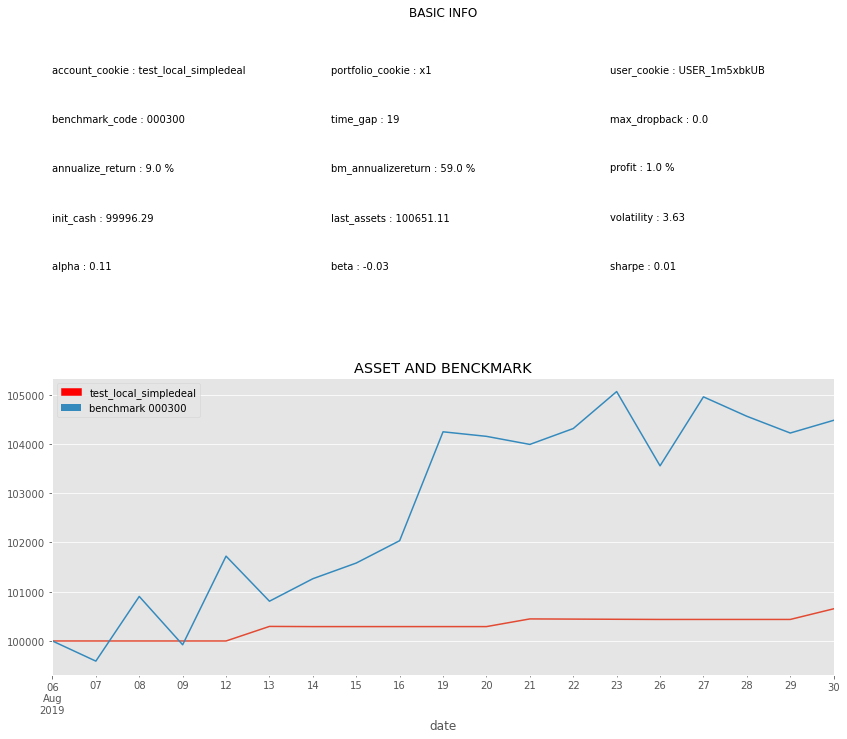

In [10]:
risk.plot_assets_curve()  # 资产曲线

In [11]:
performance.pnl  # 盈利情况

,sell_date,buy_date,amount,sell_price,buy_price,rawdirection,unit,pnl_ratio,pnl_money,hold_gap,if_buyopen,openprice,opendate,closeprice,closedate
code,,,,,,,,,,,,,,,
RBL8,2019-08-06,2019-08-13,1.0,3707.0,3677.0,sell,10,0.008159,300.0,7 days,False,3707.0,2019-08-06 00:00:00,3677.0,2019-08-13 00:00:00
RBL8,2019-08-21,2019-08-14,1.0,3686.0,3670.0,buy,10,0.004360,160.0,7 days,True,3670.0,2019-08-14 00:00:00,3686.0,2019-08-21 00:00:00
RBL8,2019-08-22,2019-08-23,1.0,3715.0,3715.0,sell,10,0.000000,0.0,1 days,False,3715.0,2019-08-22 00:00:00,3715.0,2019-08-23 00:00:00
RBL8,2019-08-26,2019-08-30,1.0,3372.0,3350.0,sell,10,0.006567,220.0,4 days,False,3372.0,2019-08-26 00:00:00,3350.0,2019-08-30 00:00:00


In [12]:
# 7. 保存结果
risk.save()

In [13]:
acc.save()